# Análisis de datos Citi Bike System NYC

## Descripción de los datos

* *date*: fecha del dato, en formato YYYY-MM-DD.
* *trips*: entero positivo, número total de viajes acumulados ese día.
* *precipitation*: entero positivo, cantidad de lluvia total registrada ese día (pulgadas).
* *snow_depth*: entero positivo, altura de nieve (pulgadas).
* *snowfall*: entero positivo, registro de precipitación en forma de nieve (pulgadas).
* *max_temperature*: entero, temperatura máxima registrada (ºF).
* *min_temperature*: entero, temperatura mínima registrada (ºF).
* *average_wind_speed*: entero, velocidad promedio del viento (MPH, millas por hora).
* *dow*: [0, 7]; código de día de la semana, 0 corresponde al domingo.
* *year*: Año del registro.
* *month*: Mes del registro.
* *holiday*: Valor lógico, indica si esa fecha es festivo (TRUE) o no (FALSE).
* *stations_in_service*: Número de estaciones para tomar o dejar bicicletas que estaban en servicio ese día.
* *weekday*: Valor lógico, indica si esa fecha corresponde a un día entre semana (de lunes a viernes, ambos inclusive).
* *weekday_non_holiday*: Valor lógico, indica si la fecha corresponde a un día entre semana festivo.

Los datos están tomados con frecuencia diaria (filas del archivo).

Importar librerías

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns
import time
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

import itertools
import warnings
import matplotlib.pyplot as plt

%matplotlib inline

Lectura del set de datos :

In [2]:
dateparse = lambda x: pd.to_datetime(x)
bikes = pd.read_csv('daily_citi_bike_trip_counts_and_weather.csv',parse_dates=['date'], date_parser=dateparse)
bikes.head(10)

,date,trips,precipitation,snow_depth,snowfall,max_temperature,min_temperature,average_wind_speed,dow,year,month,holiday,stations_in_service,weekday,weekday_non_holiday
0,2013-07-01,16650,0.838583,0.0,0.0,77.00,71.96,3.13171,1,2013,7,False,NaN,True,True
1,2013-07-02,22745,0.078740,0.0,0.0,82.04,71.96,2.68432,2,2013,7,False,NaN,True,True
2,2013-07-03,21864,0.531496,0.0,0.0,82.94,73.04,4.25018,3,2013,7,False,NaN,True,True
3,2013-07-04,22326,0.000000,0.0,0.0,87.08,75.02,4.25018,4,2013,7,True,NaN,True,False
4,2013-07-05,21842,0.000000,0.0,0.0,89.96,75.92,4.92126,5,2013,7,False,NaN,True,True
5,2013-07-06,20467,0.000000,0.0,0.0,91.94,78.08,4.47387,6,2013,7,False,NaN,False,False
6,2013-07-07,20477,0.000000,0.0,0.0,91.94,78.08,4.25018,0,2013,7,False,NaN,False,False
7,2013-07-08,21615,0.220472,0.0,0.0,89.06,73.04,4.69757,1,2013,7,False,NaN,True,True
8,2013-07-09,26641,0.228346,0.0,0.0,87.98,73.94,3.13171,2,2013,7,False,NaN,True,True
9,2013-07-10,25732,0.000000,0.0,0.0,84.92,75.02,4.25018,3,2013,7,False,NaN,True,True


Representamos el número de viajes por días y por meses de todo el set de datos:

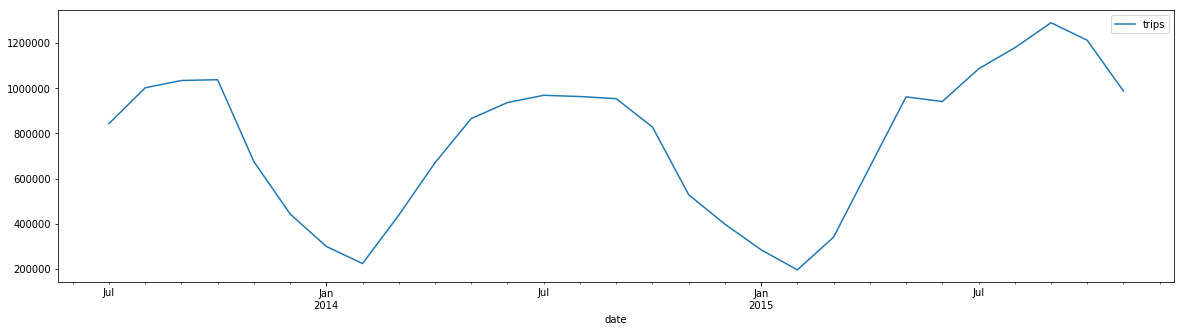

In [3]:
f, ay1 = plt.subplots(1,1,figsize=(20,5))
bikes2 = bikes.set_index('date')
tripsMonth = bikes2.resample('M').sum().reset_index()
tripsMonth.plot('date','trips', ax=ay1)

Parece que los viajes son un dato estacionario, veamos que correlación tiene con la temperatura:

In [4]:
bikes['trips'].corr(bikes['max_temperature'],'pearson')

0.7828317092557588

Encontramos una correlación muy alta (cercana al 1) por lo que podemos afirmar que los viajes dependen en gran parte de la temperatura. Podemos gráficar la relación:

/Users/victor/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/victor/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


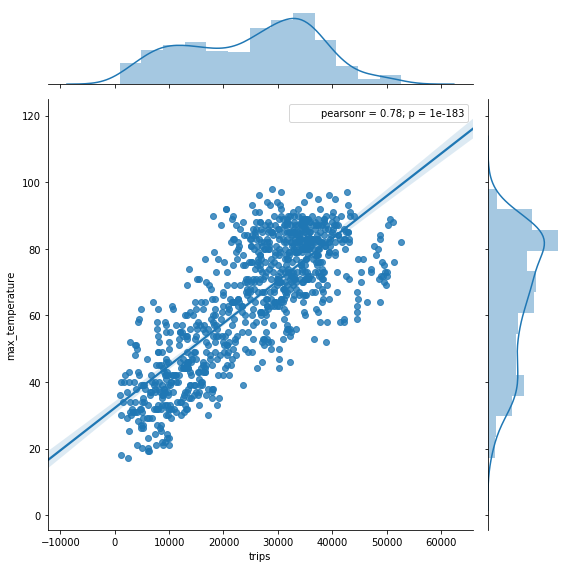

In [5]:
sns.jointplot(x='trips', y='max_temperature', data=bikes,kind='reg',size=8)

Observamos que existe una relación casi lineal entre viajes y temperatura

Veamos ahora una representación de la media de viajes por día usando un gráfico de barras agrupando por día de la semana y si es festivo o laboral.

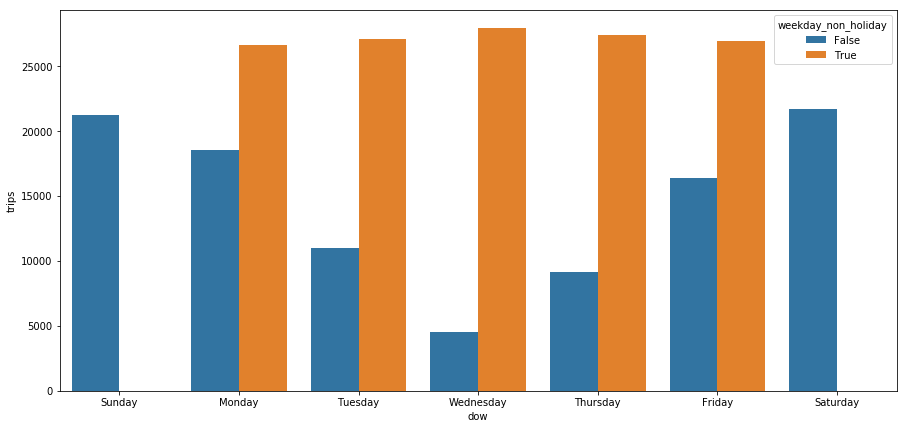

In [6]:
days = {'dow': {1: "Monday", 2: "Tuesday",3: "Wednesday", 4: "Thursday",5: "Friday", 6: "Saturday",0: "Sunday"}}
t = bikes.sort_values('dow').groupby(['dow','weekday_non_holiday']).mean()
t = t.reset_index()
var = t.replace(days)
f, (ax1) = plt.subplots(1,figsize=(15,7))
sns.barplot(x="dow", y="trips", hue="weekday_non_holiday", data=var);

En el gráfico se puede observar un menor número de viajes los días festivos comparado con el mismo día de la semana laborable.
Además, se puede ver como el número de viajes durante la semana tiende a ser constante y sin embargo decrece los fines de semana
por ello deducimos que el servicio de bicis tiene mayor uso los días laborales ya que la gente usa el servicio para ir a trabajar.

En el gráfico se puede observar que el día en el que menos viajes se realizan es el sábado y en el que más es el miércoles.Vamos a ver si se mantiene a lo largo de los años:

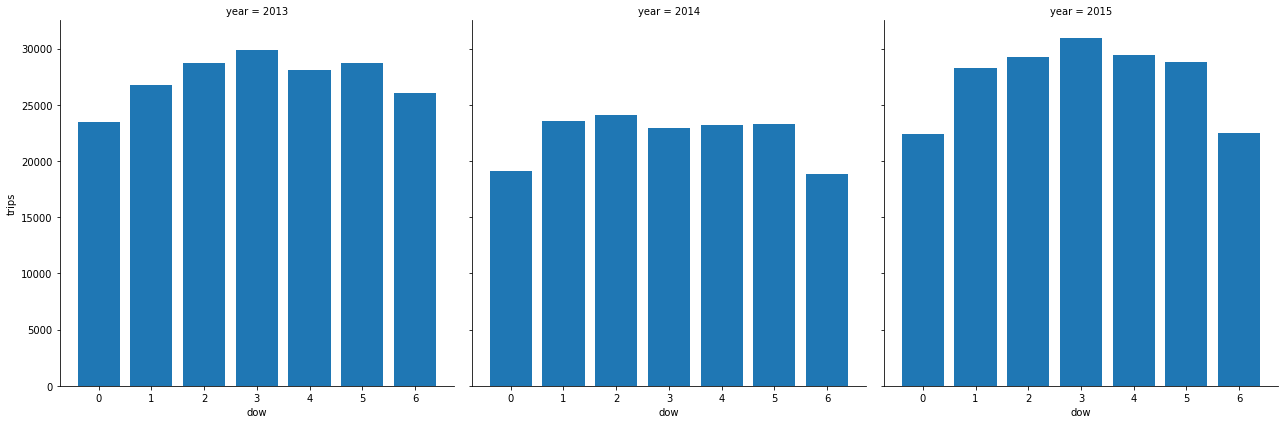

In [7]:
weekday = bikes.groupby(['dow','year']).mean().reset_index()
#weekday = weekday.replace(days)
g = sns.FacetGrid(weekday, col='year',size=6)
g.map(plt.bar, 'dow','trips');

Se puede apreciar que separando por meses el día que más viajes se realizan es el miércoles a excepción de 2014 en el que el día con más viajes es el martes. Por otra parte el día con menos viajes son los sábados excepto en 2013 que son los domingos.

# Machine Learning

In [8]:
#Separamos nuestro set de datos en train y test
train = bikes[ bikes['year'] <= 2014].dropna()
test = bikes[ bikes['year'] == 2015].dropna()

In [9]:
#Acotamos las variables a modelar y la variable objetivo a predecir
X_train = train.drop(["trips","date","holiday","stations_in_service","weekday","weekday_non_holiday"],axis=1)
X_test = test.drop(["trips","date","holiday","stations_in_service","weekday","weekday_non_holiday"],axis=1)
y_train= train['trips']
y_test = test['trips']

Exploramos el set de entrenamiento para ver sus variables. Todas han de ser numéricas debido a que la regresión lineal solo trabaja con números

In [10]:
X_train.head(5)

,precipitation,snow_depth,snowfall,max_temperature,min_temperature,average_wind_speed,dow,year,month
31,0.649606,0.0,0.0,75.92,66.02,2.90802,4,2013,8
32,0.000000,0.0,0.0,82.94,66.92,4.47387,5,2013,8
33,0.059055,0.0,0.0,78.08,68.00,3.35540,6,2013,8
34,0.000000,0.0,0.0,80.06,66.02,5.14495,0,2013,8
35,0.000000,0.0,0.0,78.08,62.06,3.35540,1,2013,8


Definimos y entrenamos nuestro modelo de regresion lineal

In [11]:
regr = linear_model.LinearRegression()
 
# Entrenamos nuestro modelo
regr.fit(X_train, y_train)
 
# Hacemos las predicciones
y_pred = regr.predict(X_train)
 
# Veamos los coeficienetes obtenidos
print('Coefficients: \n', regr.coef_)
# Este es el valor donde corta el eje Y (en X=0)
print('Independent term: \n', regr.intercept_)
# Error Cuadrado Medio
print("Mean squared error: %.2f" % mean_squared_error(y_train, y_pred))
# Puntaje de Varianza. El mejor puntaje es un 1.0
print('Variance score: %.2f' % r2_score(y_train, y_pred))

Coefficients: 
 [-7048.41729934  -408.95295091   -95.28649473   376.56540691
    42.94918788  -197.93171991   222.41286484 -3413.16806572
   -28.45445553]
Independent term: 
 6873069.407724564
Mean squared error: 24734166.29
Variance score: 0.77


Una vez entrenado el modelo vamos a predecir con nuestros datos de test y a compararlo con los resultados reales de 2015

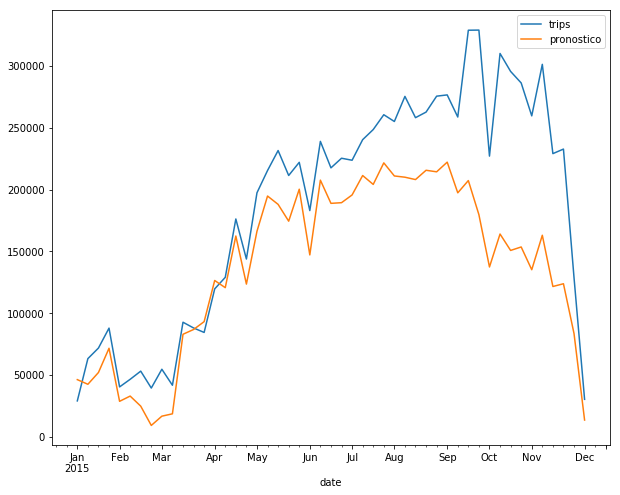

In [12]:
bikes2015 = bikes[ bikes['year'] == 2015].dropna().set_index('date')
bikes2015['pronostico'] = regr.predict(X_test)
bikes2 = bikes2015.resample('W').sum()

plot = bikes2[['trips', 'pronostico']].plot(figsize=(10, 8)) 